In [32]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import models
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf
import seaborn as sns
from sklearn.decomposition import PCA,TruncatedSVD
import torch
import torch.nn as nn
torch.manual_seed(10)
torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
corpus = [
    'Drink milk',
    'Drink cold water',
    'Drink cold cola',
    'He is drinking juice',
    'Drinking cola and juice',
    'Eat bread or rice for lunch',
    'Eat mango',
    'Eating a cherry',
    'Eating an apple',
    'Juice with sugar',
    'Cola with sugar',
    'Mango is a fruit',
    'Apple is a fruit',
    'Cherry is a fruit',
    'Berlin is in Germany',
    'Boston is in USA',
    'Mercedes is a car',
    'Mercedes is from Germany',
    'Ford is a car',
    'Ford is a car from USA'
]


## Tokenization<br>
Tokenization is done to break down the text into smaller, more manageable units. This can be achieved by simply breaking them down into individual words, although most tokenizers are a bit more complex.<br>
## Stemming <br>
Stemming is a natural language processing technique that is used to reduce words to their base form, also known as the root form. The process of stemming is used to normalize text and make it easier to process. This is usually done by removing prefixes and suffixes added to the word.<br>
## Removing stop words<br>
Stop words are common words in English that do not contribute any real meaning to the sentence. Removing these stop words speeds up processing and allows the application to focus on the more important words instead.

In [34]:
# Some of the stopwords
print(" ".join(stopwords.words('english')[:20]))

i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his


In [35]:
# The list of stopwords has been coverted into a set, making it faster to check if a given word is in it
stop_words = set(stopwords.words('english'))

In [36]:
def preprocess(corpus):
    result=[]
    for i in corpus:
        token=nltk.tokenize.word_tokenize(i)
        for j in range(0,len(token)):
            token[j]=token[j].lower()
            if token[j] in stop_words:
                token[j]=''
            token[j]=re.sub(r'ing','',token[j])
        out=' '.join(token)
        result.append(out)
    result=[nltk.tokenize.word_tokenize(text,language='english',preserve_line=True) for text in result]
    return result
#Test 

In [37]:
# Test for if the function behaves as expected, notice the last test case and expected output
test_preprocess = preprocess(['Python is a language','The cake is a lie','He is doing practice','Writing code'])
test_preprocess
assert test_preprocess == [['python', 'language'],['cake', 'lie'],['practice'],['writ', 'code']]

In [38]:
corpus=preprocess(corpus)
corpus

[['drink', 'milk'],
 ['drink', 'cold', 'water'],
 ['drink', 'cold', 'cola'],
 ['drink', 'juice'],
 ['drink', 'cola', 'juice'],
 ['eat', 'bread', 'rice', 'lunch'],
 ['eat', 'mango'],
 ['eat', 'cherry'],
 ['eat', 'apple'],
 ['juice', 'sugar'],
 ['cola', 'sugar'],
 ['mango', 'fruit'],
 ['apple', 'fruit'],
 ['cherry', 'fruit'],
 ['berlin', 'germany'],
 ['boston', 'usa'],
 ['mercedes', 'car'],
 ['mercedes', 'germany'],
 ['ford', 'car'],
 ['ford', 'car', 'usa']]

## Building the vocabulary<br>
Before we start representing words as vectors, we must first identify how many unique words our corpus

In [39]:
def create_vocabulary(corpus):
    vocabulary={}
    id=0
    for i in corpus:
        for j in range(0,len(i)):
            if i[j] not in vocabulary:
                vocabulary[i[j]]=id
                id=id+1
    return [id,vocabulary]

In [40]:
vocab_size,vocabulary = create_vocabulary(corpus)
vocabulary

{'drink': 0,
 'milk': 1,
 'cold': 2,
 'water': 3,
 'cola': 4,
 'juice': 5,
 'eat': 6,
 'bread': 7,
 'rice': 8,
 'lunch': 9,
 'mango': 10,
 'cherry': 11,
 'apple': 12,
 'sugar': 13,
 'fruit': 14,
 'berlin': 15,
 'germany': 16,
 'boston': 17,
 'usa': 18,
 'mercedes': 19,
 'car': 20,
 'ford': 21}

In [41]:
vocab_size

22

## Creating the dataset<br>
Now we analyse each sentence in the corpus and create a dataset that holds each (word, neighbour) pair.<br>
![title](q3.jpg)

In [42]:
def prepare_neighbour_set(corpus,n_gram=1):
    d=[]
    for sentence in corpus:
        for i in range(len(sentence)):
            for k in range(i-1,i-1-n_gram,-1):
                if k<0 or i==0 :
                    break
                inp=sentence[i]
                out=sentence[k]
                d.append((inp,out))
            for j in range(1,n_gram+1):
                if i==len(sentence)-1 or i+j>=len(sentence):
                    break
                inp=sentence[i]
                out=sentence[i+j]
                d.append((inp,out))
    df=pd.DataFrame(d,columns=['Input','Output'])
    return df   

In [43]:
test_neighbour = prepare_neighbour_set([['this','is','a','sentence']]).sort_values(by=['Input','Output'])

test_neighbour_expected = pd.DataFrame({
    'Input': ['this','is','is','a','a','sentence'],
    'Output': ['is','this','a','is','sentence','a']
}).sort_values(by=['Input','Output'])

In [44]:
train_emb = prepare_neighbour_set(corpus, n_gram = 2)
train_emb

,Input,Output
0,drink,milk
1,milk,drink
2,drink,cold
3,drink,water
4,cold,drink
...,...,...
59,ford,usa
60,car,ford
61,car,usa
62,usa,car


In [45]:
train_emb.Input = train_emb.Input.map(vocabulary)
train_emb.Output = train_emb.Output.map(vocabulary)
train_emb.head()

,Input,Output
0,0,1
1,1,0
2,0,2
3,0,3
4,2,0


In [46]:
train_emb['Input'].values

array([ 0,  1,  0,  0,  2,  2,  3,  3,  0,  0,  2,  2,  4,  4,  0,  5,  0,
        0,  4,  4,  5,  5,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  6, 10,
        6, 11,  6, 12,  5, 13,  4, 13, 10, 14, 12, 14, 11, 14, 15, 16, 17,
       18, 19, 20, 19, 16, 21, 20, 21, 21, 20, 20, 18, 18], dtype=int64)

In [47]:
def get_one_hot(index, vocab_size):
    # <START>
    # Create one-hot vector of size vocab_size from index
    one_hot =ohe=np.zeros((1,vocab_size))
    one_hot[0][index]=1
    # <END>
    return torch.Tensor(one_hot)

def get_input_tensor(tensor, vocab_size):
    batch_size = tensor.shape[0]
    # <START>
    # Transform 1D tensor of word indexes to one-hot encoded 2D tensor of dimensions (batch_size, vocab_size)
    inp =torch.Tensor([(get_one_hot(i,vocab_size))[0].tolist() for i in (t1.item() for t1 in tensor)])
    # <END>
    return inp

assert torch.all(get_one_hot(0,3).eq(torch.tensor([[1,0,0]])))
assert torch.all(get_input_tensor(torch.tensor([1,2,0]),3).eq(torch.tensor([[0,1,0],[0,0,1],[1,0,0]])))

![title](embedding_model.png)

In [48]:
embed_dims=4
skipgram_model = nn.Sequential(
    # <START>
    nn.Linear(vocab_size,embed_dims,bias=False),
    nn.Linear(embed_dims,vocab_size,bias=False)
    # <END>
)
num_epochs = 2000
learning_rate = 2e-1


Epoch 0, loss = 3.0794341564178467
Epoch 250, loss = 2.028237819671631
Epoch 500, loss = 1.457229733467102
Epoch 750, loss = 1.2657827138900757
Epoch 1000, loss = 1.1538469791412354
Epoch 1250, loss = 1.0991913080215454
Epoch 1500, loss = 1.0743736028671265
Epoch 1750, loss = 1.061591625213623


Text(0, 0.5, 'Loss')

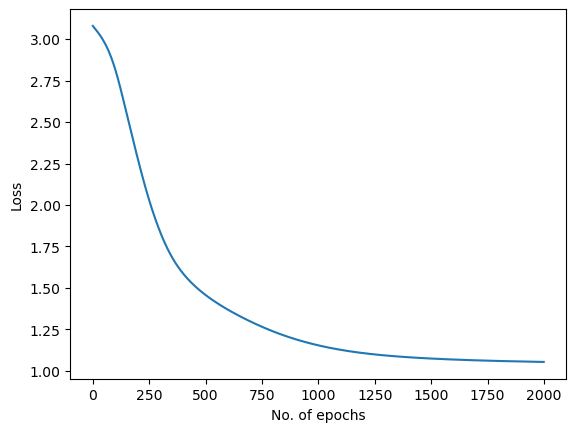

In [49]:
loss_fn = torch.nn.CrossEntropyLoss() # define loss func
loss_hist = [] # list to store loss values, to plot at the end
train_data = get_input_tensor(torch.tensor(train_emb.Input.values), vocab_size) # Should be a one-hot encoded 2D tensor
train_labels = torch.tensor(train_emb.Output.values) #Should be a 1D tensor of the indexes of the neighbor words expected
optimizer=torch.optim.SGD(skipgram_model.parameters(),lr=learning_rate)
for epo in range(num_epochs):
        # <START>
        # Compute predictions
        y_pred=skipgram_model(train_data)
        # Compute loss
        loss=loss_fn(y_pred,train_labels)
        # Reset gradients
        optimizer.zero_grad()
        # Backpropagation step
        loss.backward()
        # Update weights using gradient descent.
        optimizer.step()
        # <END>

        loss_hist.append(loss.item())

        # Print the loss every 250 epochs
        if epo%250 == 0:
          print(f'Epoch {epo}, loss = {loss}')

plt.plot(loss_hist)
plt.xlabel("No. of epochs")
plt.ylabel("Loss")

In [50]:
embeddings=skipgram_model[0].weight.detach().numpy().transpose()

In [51]:
embeddings

array([[ 0.55396646, -0.8062116 ,  1.2066821 ,  2.8810859 ],
       [-1.2093067 , -1.7816166 , -1.2136388 ,  0.6427437 ],
       [-0.62029785, -2.6655889 ,  0.5562085 ,  1.0078671 ],
       [-0.24277647, -1.0498008 , -1.5355877 ,  2.2056496 ],
       [-1.7838873 , -0.09016453, -1.041498  ,  2.302256  ],
       [-2.7699203 , -1.5135009 ,  0.3460853 ,  1.3549929 ],
       [ 1.3297483 ,  0.51669353, -2.2965198 , -1.5305177 ],
       [ 2.9284563 ,  0.5293519 , -0.29982048,  0.7605236 ],
       [ 2.3548875 , -1.8165005 , -0.62008333,  0.1165425 ],
       [ 1.778671  ,  0.07784183, -2.428672  ,  0.25768313],
       [ 1.9030246 ,  0.076547  ,  1.4975286 , -0.9946134 ],
       [ 1.8928617 ,  0.07627531,  1.5993913 , -0.869646  ],
       [ 1.89817   ,  0.08421054,  1.5451374 , -0.9299649 ],
       [-1.1221862 , -0.14411163,  1.7491035 ,  2.4206653 ],
       [ 0.5755635 ,  0.9866047 , -1.9052552 , -2.673394  ],
       [-0.16493115,  2.1345127 ,  0.35667217, -1.5927036 ],
       [-1.945254  ,  0.

In [21]:
pca=PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [22]:
pca.explained_variance_ratio_

array([0.35634765, 0.27856642], dtype=float32)

In [23]:
pca.components_

array([[-0.78423333, -0.23308617,  0.23696953,  0.52392215],
       [-0.4416207 ,  0.50936556,  0.40503597, -0.6176278 ]],
      dtype=float32)

In [24]:
embeddings.shape

(22, 4)

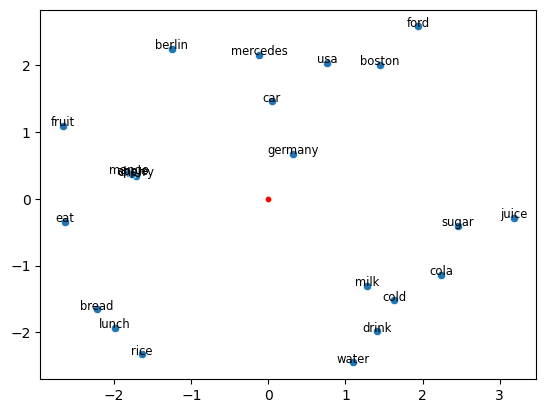

In [25]:
x=pca.transform(embeddings)[:,0]
y=pca.transform(embeddings)[:,1]
plot = sns.scatterplot(x=x, y=y)
plot.scatter(x=0, y=0, color='r',s=10)

for i in range(0,embeddings.shape[0]):
     plot.text(x[i], y[i], list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='normal');

In [60]:
#3D plot
pca_3d=PCA(n_components=3)
pca_3d.fit(embeddings)

PCA(n_components=3)

In [61]:
x_3d=pca_3d.transform(embeddings)[:,0]
y_3d=pca_3d.transform(embeddings)[:,1]
z_3d=pca_3d.transform(embeddings)[:,2]

In [62]:
x_3d

array([ 1.4147701 ,  1.278682  ,  1.6334993 ,  1.0926695 ,  2.2452803 ,
        3.1828432 , -2.6434636 , -2.2266898 , -1.643381  , -1.9876715 ,
       -1.8106079 , -1.712963  , -1.7634343 ,  2.4622517 , -2.6675968 ,
       -1.2522323 ,  0.32561237,  1.4431496 ,  0.7643907 , -0.11822799,
        0.04223824,  1.9408816 ], dtype=float32)

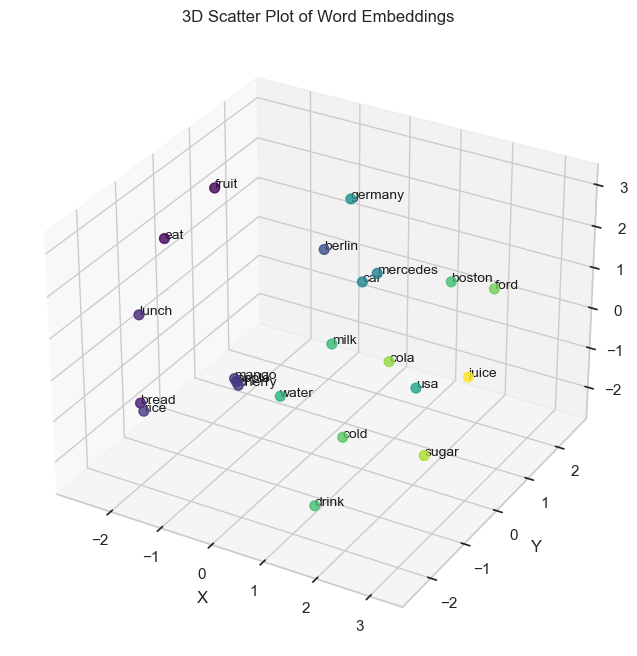

In [63]:
words=list(vocabulary.keys())
sns.set(style='whitegrid')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    x_3d,  # X-axis values
    y_3d,  # Y-axis values
    z_3d,  # Z-axis values
    c=x_3d,  # Set color to the X values or any other array of same length
    cmap='viridis',    # Choose a colormap
    s=50,              # Marker size
    alpha=0.8
)

# Add word labels
for i, word in enumerate(words):
    ax.text(
        x_3d[i], y_3d[i], z_3d[i],  # Position
        word,                                                 # Text
        size=10,                                              # Font size
        zorder=1,                                             # Layer order
        color='k'                                             # Text color
    )

# Set labels
ax.set_title('3D Scatter Plot of Word Embeddings')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [26]:
def cosine_sim(word):
  key=vocabulary[word]
  word_emb=embeddings[key]
  sim_score={}
  for i,embedding in enumerate(embeddings):
        if i==key:
            continue
        else:
            sim=np.dot(word_emb,embedding)
            sim_score[list(vocabulary.keys())[i]]=sim
  top_2 = sorted(sim_score, key=sim_score.get, reverse=True)[:2]
  return top_2

In [27]:
cosine_sim('mango')

['cherry', 'apple']

In [28]:
#Using Gensim 
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [29]:
gensim_w2v=gensim.downloader.load('word2vec-google-news-300')

In [30]:
gensim_embeddings=[]
for word in vocabulary.keys():
    gensim_embeddings.append(gensim_w2v.get_vector(word))
gensim_embeddings=np.array(gensim_embeddings)
gensim_embeddings

array([[-0.13671875, -0.27734375,  0.04736328, ..., -0.02233887,
         0.11767578, -0.06689453],
       [-0.07324219,  0.1328125 , -0.00698853, ...,  0.23828125,
         0.09472656, -0.25390625],
       [-0.0189209 ,  0.11865234, -0.0625    , ...,  0.33789062,
         0.18945312,  0.16796875],
       ...,
       [-0.07373047,  0.05517578,  0.08349609, ..., -0.00738525,
        -0.10986328,  0.08251953],
       [ 0.13085938,  0.00842285,  0.03344727, ...,  0.22851562,
        -0.14941406, -0.15039062],
       [ 0.08886719,  0.23144531, -0.03491211, ..., -0.14257812,
        -0.10888672, -0.10791016]], dtype=float32)

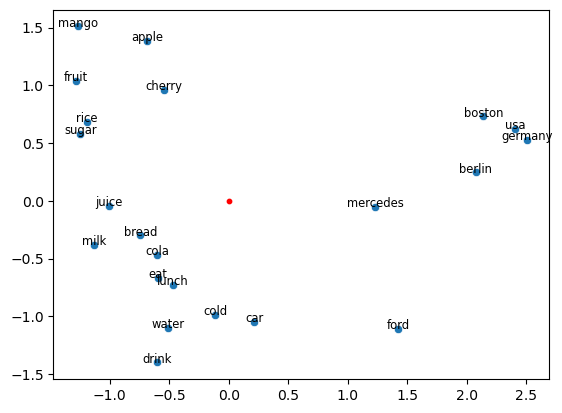

In [31]:
pca_gensim=PCA(n_components=2)
pca_gensim.fit(gensim_embeddings)
x=pca_gensim.transform(gensim_embeddings)[:,0]
y=pca_gensim.transform(gensim_embeddings)[:,1]
plot = sns.scatterplot(x=x, y=y)
plot.scatter(x=0, y=0, color='r',s=10)

for i in range(0,gensim_embeddings.shape[0]):
     plot.text(x[i], y[i], list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='normal');

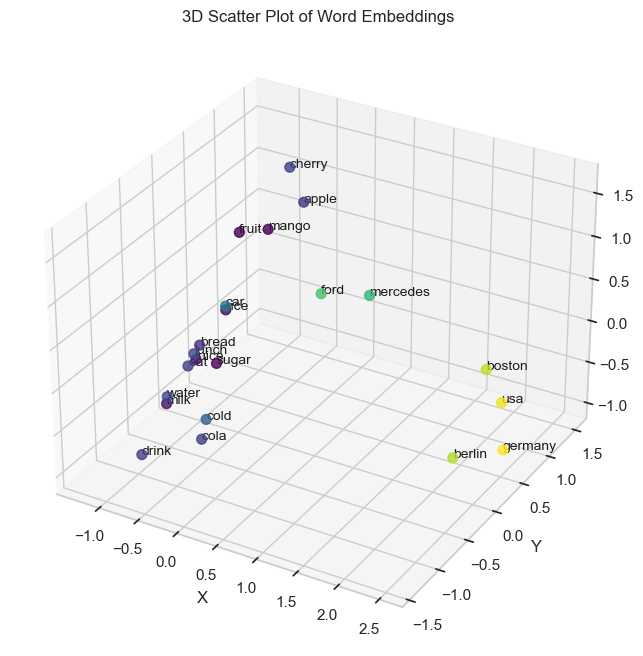

In [64]:
pca_gensim_3d=PCA(n_components=3)
pca_gensim_3d.fit(gensim_embeddings)
x_3d_g=pca_gensim_3d.transform(gensim_embeddings)[:,0]
y_3d_g=pca_gensim_3d.transform(gensim_embeddings)[:,1]
z_3d_g=pca_gensim_3d.transform(gensim_embeddings)[:,2]
words=list(vocabulary.keys())
sns.set(style='whitegrid')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    x_3d_g,  # X-axis values
    y_3d_g,  # Y-axis values
    z_3d_g,  # Z-axis values
    c=x_3d_g,  # Set color to the X values or any other array of same length
    cmap='viridis',    # Choose a colormap
    s=50,              # Marker size
    alpha=0.8
)

# Add word labels
for i, word in enumerate(words):
    ax.text(
        x_3d_g[i], y_3d_g[i], z_3d_g[i],  # Position
        word,                                                 # Text
        size=10,                                              # Font size
        zorder=1,                                             # Layer order
        color='k'                                             # Text color
    )

# Set labels
ax.set_title('3D Scatter Plot of Word Embeddings')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()